In [1]:
#Import numerical modules
import numpy as np
import numpy.linalg as LA
import math
import sys
import os

#Import plotting
import matplotlib.pyplot as plt

#Scipy optimization imports
from scipy.interpolate import CubicSpline

#File dialog imports
from tkinter import Tk
from tkinter import filedialog as fd

### Read in the necessary parameters from the command line

In [32]:
#Define the two atoms
#atom1 = sys.argv[1]
#atom2 = sys.argv[2]
atom1 = "Si"
atom2 = "Si"

In [33]:
#Define the single-atom energies
Si_energy_ry = -7.52791749
H_energy_ry = -0.92741691

ry_to_ev = 13.605698
Si_energy_ev = Si_energy_ry*ry_to_ev
H_energy_ev = H_energy_ry*ry_to_ev

In [34]:
#read in the electric potentials associated with each atomic distance
cwd = os.getcwd()
foldername = "/" + atom1 + "-" + atom2 + " DFT outputs/"
folder = cwd + foldername

bohr_to_angstrom = 0.529177
d = []
v = []
for file in os.listdir(folder):

    getEnergy=False
    coordsStart = 0
    getCoords = False
    lines = open(folder + "/" + file,"r").read().splitlines()
    for n, line in enumerate(lines):
        newline = line.split()
        if len(newline)>2:
            if newline[2] == "(alat)":
                alat = float(newline[4])*bohr_to_angstrom
                
            if newline[1] == "Fermi":
                getEnergy = True
        
            if getEnergy and newline[0] == "!" and newline[1] == "total" and newline[2] == "energy":
                energy = float(newline[4])*ry_to_ev
                if atom1 == "Si":
                    energy -= Si_energy_ev
                else:
                    energy -= H_energy_ev
                
                if atom2 == "Si":
                    energy -= Si_energy_ev
                else:
                    energy -= H_energy_ev
                v.append(energy)
            
        if line == "   Cartesian axes":
            coordsStart = n + 3
            getCoords = True
        if n==(coordsStart + 1) and getCoords:
            d.append(float(newline[6])*alat)

### Fit a cubic spline to our data

In [35]:
dArray = np.asarray(d)
vArray = np.asarray(v)

ind = np.argsort(dArray,axis=0)
dArray_sorted = np.take_along_axis(dArray, ind,axis=0)
vArray_sorted = np.take_along_axis(vArray, ind,axis=0)

cs = CubicSpline(dArray_sorted, vArray_sorted)
csder = cs.derivative()


greater_than = vArray_sorted>0
print(vArray_sorted[greater_than])
#print(dArray_sorted[greater_than])
#print(vArray_sorted[greater_than])
print(vArray_sorted)
print(csder.roots())

[65.38382884 53.56692257 42.15009403 34.06544909 27.19045248 21.32527907
 15.5861951  11.54053808  8.23743665  5.55641713  3.39865302  1.67152626
  0.50297776]
[65.38382884 53.56692257 42.15009403 34.06544909 27.19045248 21.32527907
 15.5861951  11.54053808  8.23743665  5.55641713  3.39865302  1.67152626
  0.50297776 -0.45947776 -1.38537598 -1.99629019 -2.48457542 -2.93492022
 -3.21592469 -3.34955618 -3.57571716 -3.70371508 -3.75270607 -3.6376552
 -3.44213629]
[2.21469562 2.99468205]


### Plot the data and the spline fit

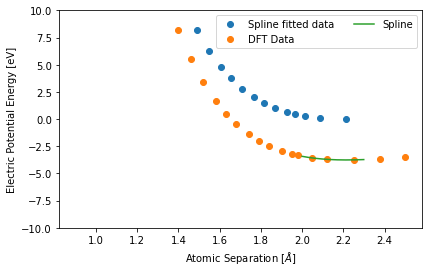

Number of points in the spline:  23


In [39]:

#Get the spline which extends from the largest positive V data point we have to 
#the zero point of the fitted spline
minPoint = csder.roots()[0]
dArray_lessthan = dArray_sorted[dArray_sorted <= minPoint]
dPoints_to_add = []
for n, i in enumerate(dArray_lessthan[:-1]):
    distance = dArray_lessthan[n+1] - i
    spacing = distance/2
    dPoints_to_add.append(i + spacing)
    #dPoints_to_add.append(i+2*spacing)
    
dPoints_to_add.append(minPoint)
dPoints_to_add.append(dArray_lessthan[0])
splineD_unsorted = np.array(dPoints_to_add)
#splineD_unsorted = np.append(splineD_unsorted, dPoints_to_add)
splineD = np.sort(splineD_unsorted)
splineV = cs(splineD)

offset = cs(minPoint)
splineV -= offset


#NOW PLOT EVERYTHING TO MAKE SURE IT LOOKS GOOD
#Si-Si mesh points: 0.8and 2.6
#Si-H mesh points: 0.6 and 1.6
#H-H mesh points: 0.25 and 0.8
finemesh = np.arange(2.0, 2.3, .001)

plt.figure(figsize=(6.5,4))
plt.plot(splineD, splineV ,'o',label='Spline fitted data')
plt.plot(dArray_sorted, vArray_sorted,'o',label='DFT Data')
plt.plot(finemesh, cs(finemesh),label='Spline')
plt.xlabel(r"Atomic Separation [${\AA}$]")
plt.ylabel("Electric Potential Energy [eV]")
plt.legend(loc='upper right',ncol=2)
plt.ylim(-10,10)
plt.show()

#zeroSlopePoint = cs.derivative().roots()[1]
#print("Bonding point at: ",zeroSlopePoint)

print("Number of points in the spline: ", len(splineD))

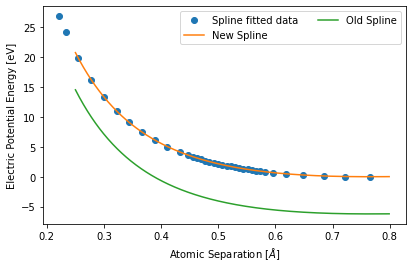

Bonding point of old spline at:  [0.96935278 0.76491908]
Bonding point of new spline at:  [0.97542255 0.76480435]
[0.22199978 0.23299977 0.25499975 0.27749972 0.2999997  0.32199968
 0.34399966 0.36599964 0.38849961 0.41099959 0.43299957 0.44749956
 0.45499955 0.46249954 0.46999953 0.47749953 0.48449952 0.49199951
 0.4994995  0.5069995  0.51449949 0.52149948 0.52899947 0.53649947
 0.54399946 0.55149945 0.55849945 0.56599944 0.57349943 0.58099942
 0.59599941 0.61799939 0.64749936 0.68449932 0.72149928 0.76491908]
[26.85661274 24.2543146  19.85259308 16.24588328 13.33140227 11.00589379
  9.09114339  7.5062094   6.16113216  5.04321963  4.13026095  3.61075034
  3.36467147  3.13284162  2.91442472  2.7086481   2.52735811  2.34402237
  2.17135347  2.00876704  1.85571819  1.72102799  1.5850065   1.4571241
  1.33696295  1.22413407  1.12511924  1.02544914  0.93210101  0.84477248
  0.68704721  0.49294965  0.29334539  0.12554898  0.03310005  0.        ]


In [30]:
#Now as a check, make a spline from the new data, and make sure it aligns
cs_new = CubicSpline(splineD, splineV)
finemesh = np.arange(0.25,0.8,.001)
plt.figure(figsize=(6.5,4))
plt.plot(splineD, splineV ,'o',label='Spline fitted data')
plt.plot(finemesh, cs_new(finemesh),label='New Spline')
plt.plot(finemesh, cs(finemesh), label='Old Spline')
plt.xlabel(r"Atomic Separation [${\AA}$]")
plt.ylabel("Electric Potential Energy [eV]")
plt.legend(loc='upper right',ncol=2)
plt.show()

zeroSlopePoint_old = cs.derivative().roots()
print("Bonding point of old spline at: ",zeroSlopePoint_old)

zeroSlopePoint_new = cs_new.derivative().roots()
print("Bonding point of new spline at: ",zeroSlopePoint_new)

print(splineD)
print(splineV)

### Export the spline in a way that it can be plugged straight into the GLUE model

In [31]:
outputFilename = "/" + atom1 + "-" + atom2 + "_newspline.txt"
outputFile = cwd + outputFilename
g = open(outputFile,'w+')
for n, item in enumerate(splineD):
    locString = "\"" + str(item).rjust(4) + "\""
    eString = "\"" + str(splineV[n]) + "\""
    g.write("<point r=" + locString + " E=" + eString + "/>\n")
g.close()